**Работа на синтетических данных**

# Импорт

In [1]:
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import pandas as pd # Библиотека Pandas для работы с табличными данными

import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
from matplotlib.colors import ListedColormap # функция библиотеки Matplotlib, которая генерирует цветовую карту

from sklearn.datasets import make_moons, make_circles, make_classification # генерируемые наборы данных

from sklearn.model_selection import train_test_split #  функция разбиения на тренировочную и тестовую выборку
# но в исполнении scikit-learn

import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px # Библиотека Plotly. Модуль "Express"

In [2]:
plt.style.use('dark_background')

Базовая модель линейной регрессии

In [3]:
class LinearRegression():
    def __init__(self,
                 learning_rate = 0.5,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        self.n_batches = n_batches


    #---------------------------------
    def forward(self, X):
        # умножаем признаки на веса
        return np.dot(X, self.weights)

    #---------------------------------
    def loss(self,yhat, y):
        # расчет функции потерь
        return np.square(yhat - y).sum()/y.size

    #---------------------------------
    def grad_step(self,yhat, y, X):
        # расчет градиента
        return 2*np.dot(X.T, (yhat - y)) / y.size

    #---------------------------------
    def update(self):
        # обновление весов
        return self.weights - self.lr*self.grad

    #---------------------------------
    def init(self, weights_size):
        # инициализируем веса
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)

    #---------------------------------
    def predict(self, X):
        # делем предсказание модели
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()

    #---------------------------------
    def score(self, X, y):
        # оценка по коэффициенту детерминации
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

    #---------------------------------
    def fit(self, X, y):
        # обучение модели с учетом разбиения на батчи
        np.random.seed(self.seed)

        if self.weights is None: # если веса не заданы - задаем
            self.weights = self.init(X.shape[1])

        if self.bias is None: # если смещение не задано - задаем
            self.bias    = self.init(1)

        if self.weights.size == X.shape[1]: # если веса заданы, но не добавлено смещение - объединяем
            self.weights = np.append(self.bias,self.weights)

        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:   # проверка на согласование размерности батча и размерности данных
            self.batch_size = y.size

        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size

        for i in range(self.epochs): #циклы обучения, как раньше
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)):

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch)
                self.weights = self.update()
                loss += self.loss(yhat,  y_batch)

                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches

        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        # загрузка батча
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch) # тут мы всегда добавляем смещение
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch

    #---------------------------------
    def add_bias(self, X):
        # добавление смещения
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = 'Кривая обучения'):
        # отрисовка сразу в методе
        fig = go.Figure()
            # рисуем с помощью библиотеки plotly
        fig.add_trace(
                go.Scatter(
                y=self.cost,
                mode='lines+markers',
                name='Реальные данные',

                )
            )
        fig.update_layout(
                    title=title,
                    width=1200,
                    height=600,
                template = "plotly_dark"
                    )

        fig.show()

    #---------------------------------
    def get_w_and_b(self):
        # "новый" метод - который возвращает веса модели и смещение
        return (self.weights[1:], self.bias)

Класс эластичной регрессии

In [4]:
class ElasticRegression(LinearRegression): #унаследуем всё что можно от "базовой" модели
    def __init__(self,
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty

    #---------------------------------
    def loss(self,yhat, y):
        # изменяем функцию потерь
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term

    #---------------------------------
    def update(self):
        # изменяем правило обновление весов
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

функция, которая позволит нам отрисовывать двумерные данные для классификации

In [5]:
def plot_data(ax, ds, name='', marker='o', colors=["#ff0000", "#0000ff"], alpha=0.7, s=150, facecolor=True):
    # Распаковываем признаки и целевые метки
    X, y = ds

    # Убедимся, что метки классов y являются целыми числами
    if not np.issubdtype(y.dtype, np.integer):
        y = y.astype(int)

    # Создаем карту цветов на основе заданных цветов
    try:
        cm_bright = ListedColormap(colors)
    except ValueError:
        raise ValueError("Неверный формат цвета. Используйте цвета в формате '#RRGGBB'.")

    # Устанавливаем название графика
    ax.set_title(name, fontsize=15)

    # Построение scatter-графика с заливкой или без неё
    if facecolor:
        sc = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, marker=marker, s=s, alpha=alpha)
    else:
        sc = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, marker=marker, s=s, facecolors='none', alpha=alpha)

    # Настройка границ и сетки
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(True)
    ax.set_xticks(())
    ax.set_yticks(())

функция отрисовки весов

In [6]:
def vis_weigths(weights):
    numbers = np.arange(0,len(weights)) # создаем массив от 0 до количество весов-1
    tick_labels = np.array(['w'+str(num) for num in numbers]) # создаем "названия" весов


    fig = go.Figure()
    fig.add_trace(go.Bar(x=numbers[weights<0], y=weights[weights<0],
                    marker_color='red',
                    name='отрицательные веса'))
    fig.add_trace(go.Bar(x=numbers[weights>=0], y=weights[weights>=0],
                    marker_color='blue',
                    name='положительные веса'
                    ))

    fig.update_layout(
                title="Веса модели",
                width=1200,
                height=600,
                template = "plotly_dark",
                xaxis = dict(
                                         tickmode = 'array',
                                         tickvals = numbers,
                                         ticktext = tick_labels,
                                         )
                )

    fig.show()

# Генерация распределения

Создание синтетического набора данных для распределения инь-янь

In [7]:
def make_binary_clf(N, noises = 0.15, random_state = 42):
    # фиксируем случайный seed
    if random_state: rng = np.random.RandomState(seed = random_state)

    # если выбран метод moons
    # то мы создаем набор данных с использованием функции make_moons
    # это будут данные похожие на Инь-Ян
    X, y = make_moons(n_samples=N, # количество точек
                      noise=noises, # уровень шума
                      random_state=random_state # фиксированный сид случайных чисел
                      )
    return X,y

Визуализируем

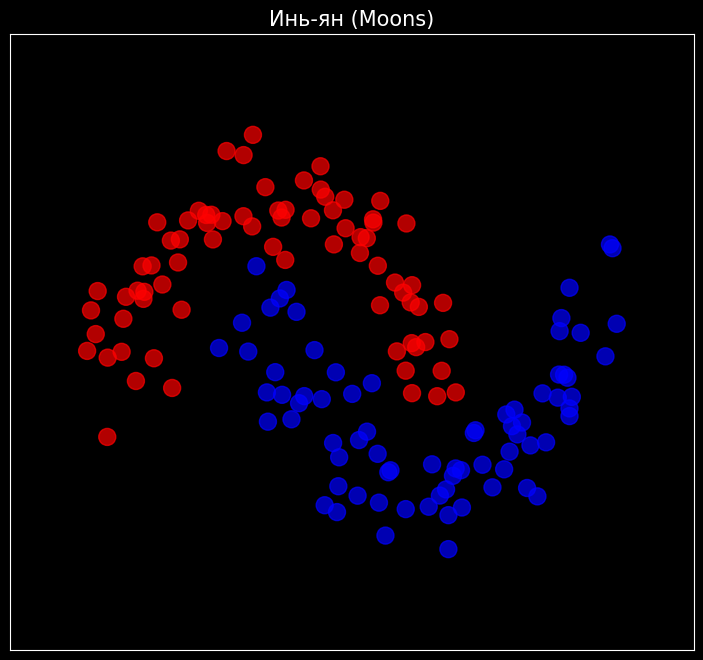

In [8]:
#@title данные { run: "auto" }
N = 150 #@param {type:"slider", min:50, max:250, step:25}
noises = 0.15 #@param {type:"slider", min:0, max:1, step:0.05}
# слайдерами можно изменять количество точек и уровень шума
# И - Интерактивностб

fig=plt.figure(figsize=(30,8))

ax = plt.subplot(1, 3, 1)
plot_data(ax,make_binary_clf(N),
          'Инь-ян (Moons)')


# Обучение модели логистической регрессии

Напишем класс логистической регрессии. Добвим к нему функцию эластичной регуляризации

In [9]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    # унаследуем всё что можно от модели линейной регрессии с эластичной регуляризацией
    def __init__(self,
                 learning_rate = 0.5,
                 l1_penalty    = 0.0,
                 l2_penalty    = 0.0,
                 epochs        = 100,
                 weights       = None,
                 bias          = None,
                 threshold     = 0.5,
                 batch_size    = 1000,
                 n_batches     = None,
                 random_state  = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    #---------------------------------
    def loss(self,yhat, y):
        # изменяем функцию потерь - на бинарную кросс-энтропию
        l1_term = self.l1_penalty*np.sum(self.weights[1:])
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        # добавки от регуляризации остаются прежде
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term
    #---------------------------------
    def sigmoid(self, z):
        # определение функции сигмоиды
        return 1 / (1 + np.exp(-z))
    #---------------------------------
    def forward(self, X):
        # умножаем признаки на веса и применяем к результату сигмоиду
        return self.sigmoid(np.dot(X, self.weights))
    #---------------------------------
    def to_class(self,logit):
        # классифицируем сравнивая с порогом
        return (logit>=self.threshold)*1
    #---------------------------------
    def predict(self, X):
        # предсказание модели
        # в этот раз в два этапа
        yhat = self.forward(self.add_bias(X)) # 1 - считаем модель
        return self.to_class(yhat) # 2 классифицируем по порогу

    #---------------------------------
    def predict_prob(self, X):
        # предсказание модели, но в "вероятностном виде"
        yhat = self.forward(self.add_bias(X))
        return yhat # для этого просто возвращаем модель
    #---------------------------------
    def score(self, X, y):
        # оценка модели
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size # по количеству совпавших предсказаний - Accuracy
    #---------------------------------
    def plot_desicion_function(self,X,y,figsize = (12,6),
                               marker = 'o',colors =["#ff0000", '#0000ff'],
                               alpha=0.7, s = 150, poly = False, order = 2):
        # отрисовка функции принятия решений
        plt.figure(figsize = figsize) # создаем новое полотно
        cm_bright = ListedColormap(colors) # создаем цветовую карту
        # отрисовыаем исходные данные
        plt.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, alpha =alpha);

        h =  (X[:, 0].max() - X[:, 0].min())/50 # шаг сетки как 1/50 от разницы между минимумом и максимумом
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 # фиксируем минимальные и максимальные значения по горизонтали
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 # фиксируем минимальные и максимальные значения по вертикали
        # создаем пары "иксов и игреков" (горизонтальных и вертикальных признаков)
        # равномерно распределенных от минимальных до максимальных значений с шагом h
        # т.е. мы разбиваем область значений входных данных на равномерную сетку
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        if poly: # небольшой спойлер - если мы используем полиномиальные признаки
        # то нашу сетку нужно преобразовать в соответсвующие полиномы. иначе модель нас не поймет
            # считаем предсказание модели в "вероятностном виде"
            # с помощью метода ravel "выпрямляем" сетку в столбцы
            Z = self.predict_prob(to_polynom(np.c_[xx.ravel(), yy.ravel()],order))-0.5
            # вычитаем 0.5, чтобы центровать вероятности: если модель не уверена, то будет 0
        else:
            # считаем предсказание модели в "вероятностном виде"
            # с помощью метода ravel "выпрямляем" сетку в столбцы
            Z = self.predict_prob(np.c_[xx.ravel(), yy.ravel()])-0.5
            # вычитаем 0.5, чтобы центровать вероятности: если модель не уверена, то будет 0
        cm = plt.cm.RdBu #
        Z = Z.reshape(xx.shape) # обратно преобразуем строку в сетку
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.5) # отрисовываем контур вероятности
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()
    #---------------------------------
    def classification_report(self, X,y):
        # считаем различные метрики классификации
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives

        yhat  = self.predict(X)
        total = yhat.size
        n= sum(yhat==0)
        p = sum(yhat==1)
        # перебираем все точки и в ручную заполняем матрицу ошибок
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1
        # пишем все метрики
        print('True Positives:%.4f'%(tp/p), end = '\t')
        print('False Positives:%.4f'%(fp/p))
        print('False Negatives:%.4f'%(fn/n), end = '\t')
        print('True Negatives:%.4f'%(tn/n))
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

Подготовим данные для классификации

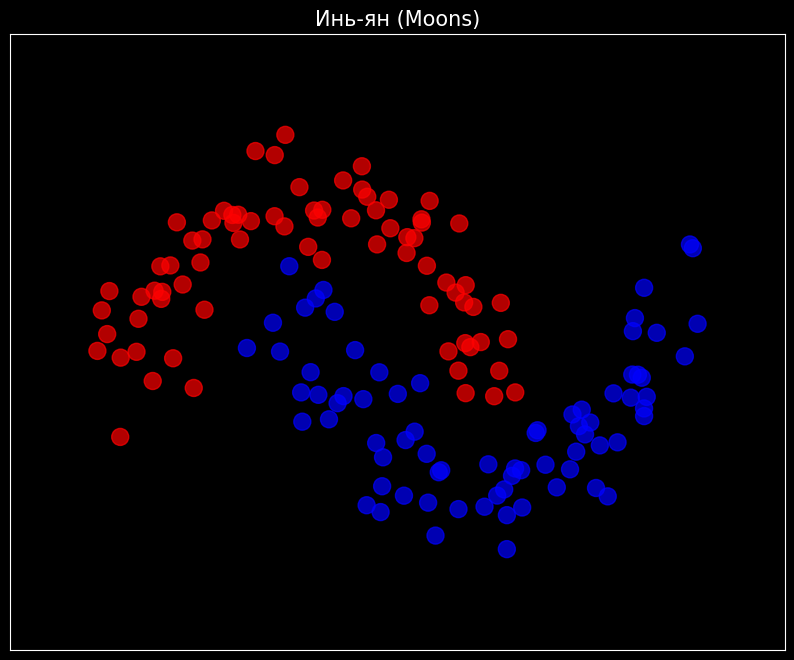

In [10]:
X,y = make_binary_clf(N)

# никогда не забываем хотя бы разделять на тренировочную и тестовую (валидационную)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# визуализируем
fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X,y),
          'Инь-ян (Moons)')

Проведем тестирование без регуляризации по отработанной стратегии

Создаем модель-объект

Обучаем через .fit()

Оцениваем через .score()

Рисуем функцию потерь через .plot_cost()

добавляется пункт

Оценка метрик классификации через .classification_report()

In [11]:
regr = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

0.8222222222222222 0.8571428571428571
True Positives:0.8889	False Positives:0.1111
False Negatives:0.2222	True Negatives:0.7778
Accuracy:0.8222
Recall:0.7273	Precision:0.8889
f1 measure:0.8000


**Мини выводы:**

Преобладает ошибка первого рода.

С точностью до 82% модель делает верный прогноз.

73% объектов положительного класса из всех объектов положительного класса нашёл алгоритм.

89% объектов, названных моделью положительными действительно являются положительными.

F1-мера 0.8 - это означает что, модель хорошо работает при минимальном количестве ложноположительных и ложноотрицательных результатов.

веса модели

In [12]:
w, b = regr.get_w_and_b()
print(w,b)

[ 1.29762749 -5.10203689] 0.6958353589495131


In [13]:
vis_weigths(np.hstack([b,w]))

модель определила 3 веса

отрисуем функцию принятия решений

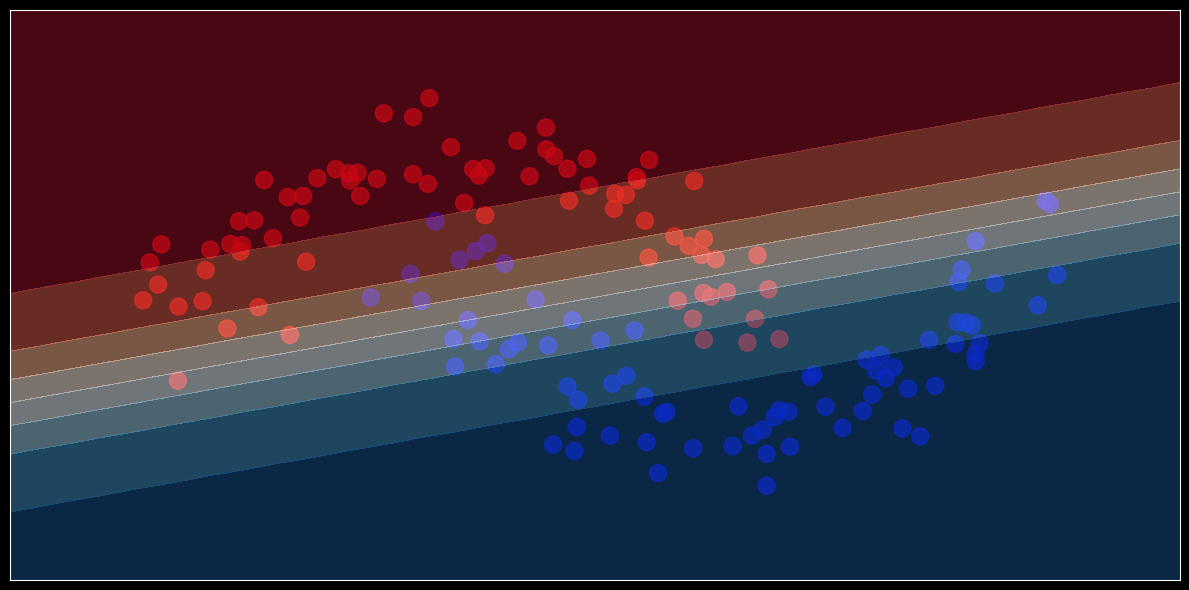

In [14]:
regr.plot_desicion_function(X,y)

не идеально, но тоже неплохо

#Логистическая регрессия с генерацией полиномиальных признаков

попробуем проделать все это с помощью добавления полиномиальных признаков

In [15]:
def to_polynom(X, order = 2):
    if order <2: # чтобы не пытались вставить отрицательные степени
        order = 2

    order_range = range(2, order+1,1)
    out = np.copy(X)
    for i in order_range:
        out = np.hstack([out, np.power(X,i)]) # складываем в выходную переменную все степени от 2 до order
    return out

In [16]:
X_poly   = to_polynom(X, order = 2)  # из исходых данных генерируем полиномы второй степени

#  не забываем хотя бы разделять на тренировочную и тестовую (валидационную)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

In [17]:
regr_poly = LogisticRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr_poly.fit(X_train, y_train)

regr_poly.plot_cost()

print(regr_poly.score(X_test, y_test), regr_poly.score(X_train, y_train))

regr_poly.classification_report(X_test, y_test)

0.8222222222222222 0.8666666666666667
True Positives:0.8889	False Positives:0.1111
False Negatives:0.2222	True Negatives:0.7778
Accuracy:0.8222
Recall:0.7273	Precision:0.8889
f1 measure:0.8000


**Мини выводы:**

Преобладает ошибка первого рода.

С точностью до 82% модель делает верный прогноз.

73% объектов положительного класса из всех объектов положительного класса нашёл алгоритм.

89% объектов, названных моделью положительными действительно являются положительными.

F1-мера 0.8 - это означает что, модель хорошо работает при минимальном количестве ложноположительных и ложноотрицательных результатов.

В целом, особых отличий от регрессии без полиномиальных признаков нет

In [18]:
w, b = regr_poly.get_w_and_b()
print(w,b)

[ 1.13592632 -5.25517398  0.15945717  0.3585257 ] 0.5758286332384561


In [19]:
vis_weigths(np.hstack([b,w]))

теперь модель определяет 5 весов

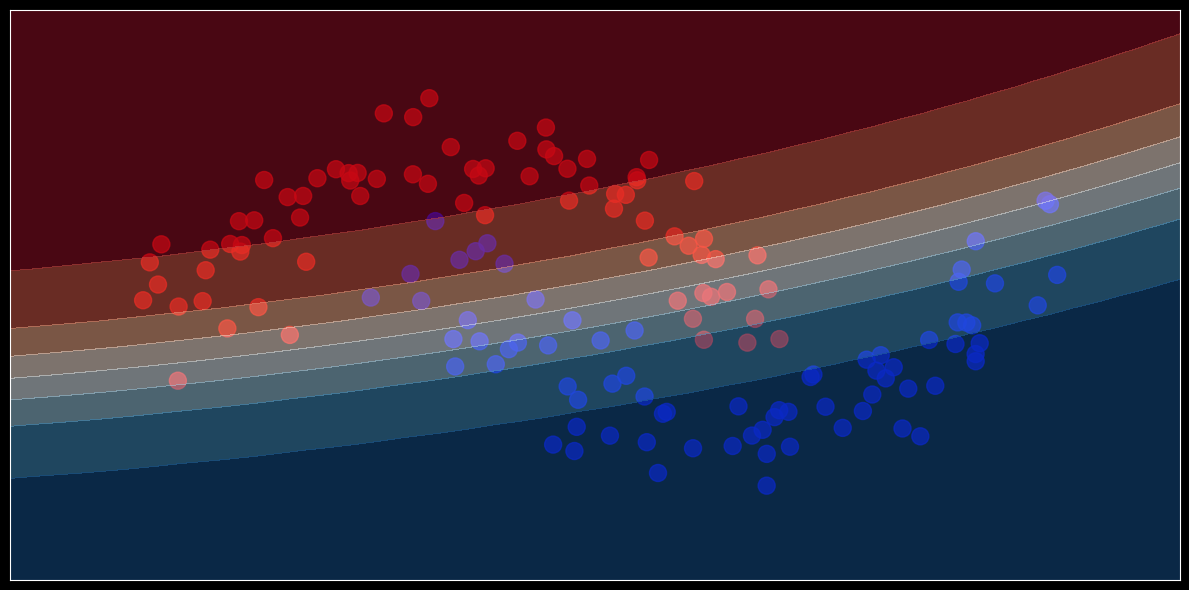

In [20]:
regr_poly.plot_desicion_function(X_poly,y,
                            poly = True, order = 2)

по этому графику видно, что на самом деле, модель стала предсказывать чуть лучше.

#Регуляризация L1

In [21]:
class LassoRegression(LogisticRegression): #унаследуем всё что можно от "базовой" модели
    def __init__(self,
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty

    #---------------------------------
    def loss(self,yhat, y):
        # изменяем функцию потерь
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term

    #---------------------------------
    def update(self):
        # изменяем правило обновление весов
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty)

In [22]:
X_L1,y_L1 = make_binary_clf(N)

# никогда не забываем хотя бы разделять на тренировочную и тестовую (валидационную)
X_L1_train, X_L1_test, y_L1_train, y_L1_test = train_test_split(X_L1, y_L1, test_size=0.3, random_state=42)

In [23]:
regr_L1 = LassoRegression(learning_rate=0.25,
                          epochs=500,batch_size=50,
                          )

regr_L1.fit(X_L1_train, y_L1_train)

regr_L1.plot_cost()

print(regr_L1.score(X_L1_test, y_L1_test), regr_L1.score(X_L1_train, y_L1_train))

regr_L1.classification_report(X_L1_test, y_L1_test)

0.8222222222222222 0.8571428571428571
True Positives:0.8889	False Positives:0.1111
False Negatives:0.2222	True Negatives:0.7778
Accuracy:0.8222
Recall:0.7273	Precision:0.8889
f1 measure:0.8000


In [24]:
w, b = regr_L1.get_w_and_b()
print(w,b)

[ 1.29062888 -5.02570792] 0.6742990317278756


In [25]:
vis_weigths(np.hstack([b,w]))

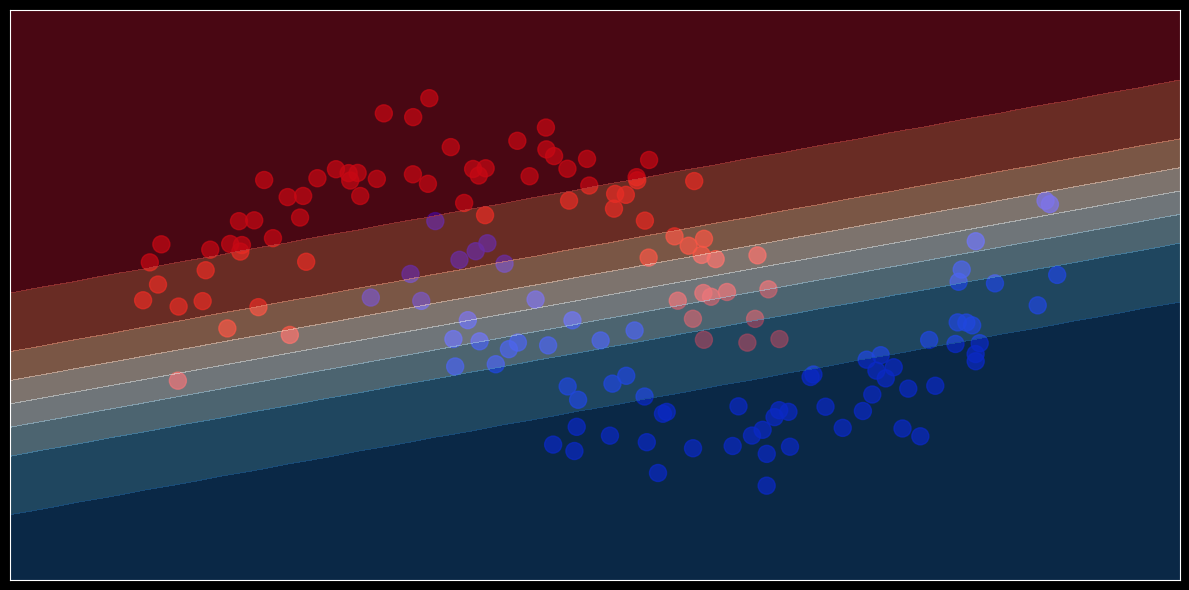

In [26]:
regr_L1.plot_desicion_function(X_L1, y_L1)

блин блинский, ничего не изменилось